# Part 2: Simple Text Processing
# Tokenization, Lemmatization, Word Frequency, Vectorization

In [27]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
import spacy
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pickle
from pathlib import Path

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Create outputs directory
Path("outputs").mkdir(exist_ok=True)

In [29]:
# Load the SOTU dataset
sotu = pd.read_csv('data/SOTU.csv')

print(f"\nDataset loaded successfully!")
print(f"Shape: {sotu.shape}")
print(f"Columns: {sotu.columns.tolist()}")
print(f"Total speeches: {len(sotu)}")
print(f"Year range: {sotu['Year'].min()} - {sotu['Year'].max()}")


Dataset loaded successfully!
Shape: (246, 4)
Columns: ['President', 'Year', 'Text', 'Word Count']
Total speeches: 246
Year range: 1790.0 - 2024.0


In [30]:
nlp = spacy.load("en_core_web_sm")

In [31]:
print("SUBSETTING DATA (2000 ONWARDS)")

sotu_2000 = sotu[sotu['Year'] >= 2000].copy()

print(f"\nFiltered dataset for analysis:")
print(f"  Speeches from 2000+: {len(sotu_2000)}")
print(f"  Year range: {sotu_2000['Year'].min()} - {sotu_2000['Year'].max()}")


SUBSETTING DATA (2000 ONWARDS)

Filtered dataset for analysis:
  Speeches from 2000+: 25
  Year range: 2000.0 - 2024.0


In [32]:
print("PROCESSING SPEECHES WITH SPACY (2000+ only)")

# Process speeches from 2000+ using nlp.pipe() for efficiency
processed_docs = []

for doc in tqdm(nlp.pipe(sotu_2000['Text'].tolist(), batch_size=50), 
                total=len(sotu_2000), 
                desc="Processing speeches"):
    processed_docs.append(doc)

SECTION 1: PROCESSING SPEECHES WITH SPACY (2000+ only)


Processing speeches: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


In [33]:
print("ANALYZE TOKENS VS LEMMAS")

# TOKEN LIST

print("\n--- Creating Token List ---")

all_tokens = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_tokens.append(token.text.lower())

token_counts = Counter(all_tokens)
top_25_tokens = token_counts.most_common(25)

print(f"\nTotal tokens: {len(all_tokens):,}")
print(f"Unique tokens: {len(token_counts):,}")
print(f"\nTop 25 Tokens:")
print(top_25_tokens)


SECTION 2: ANALYZE TOKENS VS LEMMAS

--- Creating Token List ---

Total tokens: 75,983
Unique tokens: 8,948

Top 25 Tokens:
[('america', 816), ('people', 637), ('american', 582), ('new', 530), ('years', 439), ('americans', 437), ('world', 425), ('year', 406), ('country', 369), ('jobs', 348), ('tonight', 344), ('work', 324), ('know', 323), ('let', 320), ('congress', 317), ('nation', 311), ('time', 301), ('help', 282), ('need', 266), ('tax', 255), ('president', 247), ('economy', 243), ('like', 241), ('right', 240), ('want', 237)]


In [34]:
all_lemmas = []

for doc in processed_docs:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            all_lemmas.append(token.lemma_.lower())

lemma_counts = Counter(all_lemmas)
top_25_lemmas = lemma_counts.most_common(25)

print(f"\nTotal lemmas: {len(all_lemmas):,}")
print(f"Unique lemmas: {len(lemma_counts):,}")
print(f"\nTop 25 Lemmas:")
print(top_25_lemmas)



Total lemmas: 75,983
Unique lemmas: 6,726

Top 25 Lemmas:
[('year', 845), ('america', 816), ('people', 639), ('american', 587), ('work', 557), ('new', 532), ('job', 486), ('country', 435), ('americans', 432), ('world', 426), ('know', 395), ('nation', 388), ('help', 378), ('need', 353), ('time', 351), ('tonight', 344), ('child', 332), ('let', 326), ('congress', 317), ('come', 301), ('family', 296), ('good', 294), ('right', 282), ('million', 274), ('want', 264)]


In [35]:
print("\n--- Token vs Lemma Comparison ---")

# Compare "year" and "years"
year_count = token_counts.get('year', 0)
years_count = token_counts.get('years', 0)
year_lemma_count = lemma_counts.get('year', 0)

print(f"\nComparison for 'year'/'years':")
print(f"  Token 'year': {year_count}")
print(f"  Token 'years': {years_count}")
print(f"  Lemma 'year': {year_lemma_count}")

# Compare "child" and "children"
child_count = token_counts.get('child', 0)
children_count = token_counts.get('children', 0)
child_lemma_count = lemma_counts.get('child', 0)

print(f"\nComparison for 'child'/'children':")
print(f"  Token 'child': {child_count}")
print(f"  Token 'children': {children_count}")
print(f"  Lemma 'child': {child_lemma_count}")



--- Token vs Lemma Comparison ---

Comparison for 'year'/'years':
  Token 'year': 406
  Token 'years': 439
  Lemma 'year': 845

Comparison for 'child'/'children':
  Token 'child': 119
  Token 'children': 215
  Lemma 'child': 332


In [36]:
print("COMMON WORDS ANALYSIS")

def get_most_common_words(df, year, n=25):
    """
    Get the n most common lemmas for a given year.
    
    Parameters:
    -----------
    df : DataFrame
        SOTU dataframe with 'Year' and 'Text' columns
    year : int or float
        Year of interest
    n : int
        Number of top words to return
        
    Returns:
    --------
    list of tuples: (lemma, count) for top n words
    """
    # Subset for the year
    df_year = df[df['Year'] == year]
    
    if len(df_year) == 0:
        print(f"No speeches found for year {year}")
        return []
    
    # Process and extract lemmas
    year_lemmas = []
    for doc in nlp.pipe(df_year['Text'].tolist()):
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                year_lemmas.append(token.lemma_.lower())
    
    # Count and return top n
    return Counter(year_lemmas).most_common(n)

# Test on 2024
print("\n--- Testing function on 2024 ---")
words_2024 = get_most_common_words(sotu, 2024, n=10)
print("\nTop 10 words for 2024:")
print(words_2024)

SECTION 3: COMMON WORDS ANALYSIS

--- Testing function on 2024 ---

Top 10 words for 2024:
[('president', 58), ('year', 45), ('america', 44), ('american', 34), ('people', 33), ('$', 33), ('member', 32), ('want', 29), ('audience', 29), ('know', 29)]


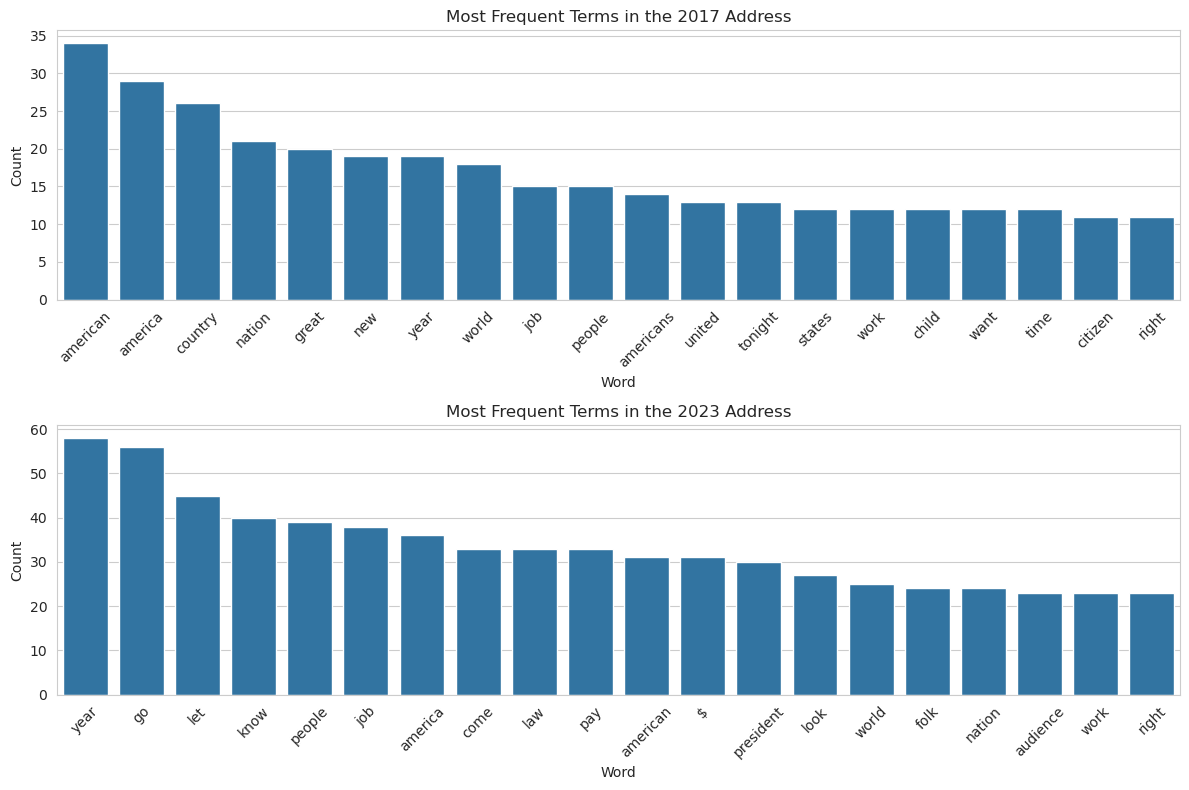

In [42]:
# Create DataFrames for easier plotting
df_2017 = pd.DataFrame(words_2017, columns=["Word", "Count"])
df_2023 = pd.DataFrame(words_2023, columns=["Word", "Count"])

# Draw the bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Chart for 2017
sns.barplot(data=df_2017, x="Word", y="Count", ax=axes[0])
axes[0].set_title("Most Frequent Terms in the 2017 Address")
axes[0].tick_params(axis="x", rotation=45)

# Chart for 2023
sns.barplot(data=df_2023, x="Word", y="Count", ax=axes[1])
axes[1].set_title("Most Frequent Terms in the 2023 Address")
axes[1].tick_params(axis="x", rotation=45)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig("outputs/2.1_State_of_the_Union_Most_Frequent_Words.png", dpi=300, bbox_inches="tight")
plt.show()


In [38]:
# TF-IDF VECTORIZATION (2000+ ONLY)

print("TF-IDF VECTORIZATION")

print("\nProcessing speeches from 2000+ for TF-IDF vectorization...")

# 1. Create lemmatized documents for 2000+ only
lemmatized_docs_2000 = []

for doc in tqdm(processed_docs, 
                total=len(processed_docs), 
                desc="Lemmatizing 2000+ speeches"):
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    lemmatized_docs_2000.append(" ".join(lemmas))

# 2. Train TF-IDF vectorizer on ONLY 2000+ speeches
vectorizer_2000 = TfidfVectorizer(
    max_features=1000,
    min_df=1,
    max_df=0.85
)

tfidf_matrix_2000 = vectorizer_2000.fit_transform(lemmatized_docs_2000)

print("\nTF-IDF Matrix (2000+):")
print(f"  Shape: {tfidf_matrix_2000.shape}")
print(f"  Speeches: {tfidf_matrix_2000.shape[0]}")
print(f"  Features: {tfidf_matrix_2000.shape[1]}")

# 3. Save for use in Part 3 and later sections
with open("outputs/tfidf_vectorizer_2000.pkl", "wb") as f:
    pickle.dump(vectorizer_2000, f)

with open("outputs/tfidf_matrix_2000.pkl", "wb") as f:
    pickle.dump(tfidf_matrix_2000, f)

with open("outputs/lemmatized_docs_2000.pkl", "wb") as f:
    pickle.dump(lemmatized_docs_2000, f)


SECTION 5: TF-IDF VECTORIZATION (2000+ ONLY)

Processing speeches from 2000+ for TF-IDF vectorization...


Lemmatizing 2000+ speeches: 100%|██████████| 25/25 [00:00<00:00, 374.13it/s]

✓ Created 25 lemmatized docs (2000+)

TF-IDF Matrix (2000+):
  Shape: (25, 1000)
  Speeches: 25
  Features: 1000

✓ Saved TF-IDF outputs for 2000+ speeches


TF-IDF matrix shape: (246, 25957)


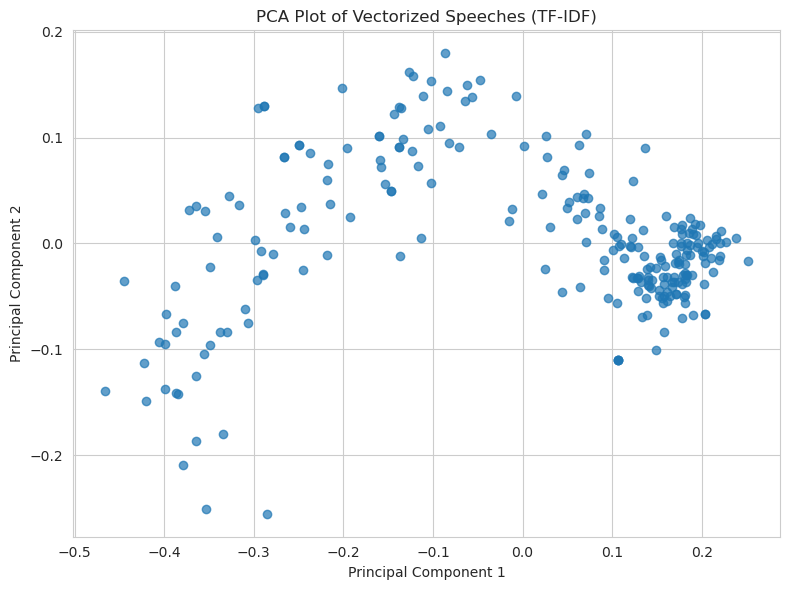

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Convert speech texts to a list
raw_docs = sotu["Text"].to_list()

# Initialize TF-IDF vectorizer (default tokenizer is fine)
tfidf_model = TfidfVectorizer()

# Fit the model and transform the speeches into TF-IDF vectors
tfidf_vectors = tfidf_model.fit_transform(raw_docs).toarray()

print(f"TF-IDF matrix shape: {tfidf_vectors.shape}")

pca = PCA(n_components=2)

# Create DataFrame where each speech = a row, each column = a PCA projection
df2d = pd.DataFrame(pca.fit_transform(tfidf_vectors), columns=["x", "y"])

plt.figure(figsize=(8, 6))
plt.scatter(df2d["x"], df2d["y"], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot of Vectorized Speeches (TF-IDF)")
plt.tight_layout()
plt.savefig("outputs/vectorized_speeches_principal_components.png")
plt.show()

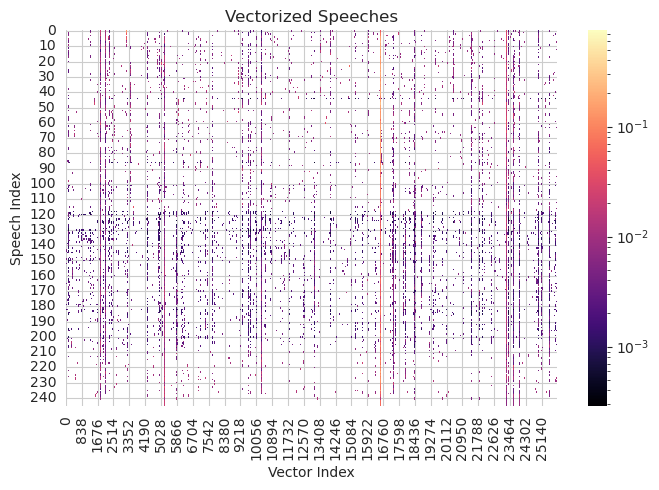

In [40]:
# TF-IDF HEATMAP WITH LOG-SCALED COLOR AXIS
from matplotlib.colors import LogNorm

# Convert sparse matrix → dense matrix
dense_tfidf = tfidf_vectors  # Already dense if you used .toarray() earlier
# If yours is sparse, uncomment:
# dense_tfidf = tfidf_vectors.toarray()

plt.figure(figsize=(7, 5))

sns.heatmap(
    dense_tfidf,
    norm=LogNorm(),
    cmap="magma",
)

plt.title("Vectorized Speeches")
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")

plt.tight_layout()
plt.savefig("outputs/2.3_Vectorized_Speeches.png", dpi=300, bbox_inches="tight")
plt.show()


In [41]:
# List of frequent words across the corpus
word_list = [
    'year', 'america', 'people', 'american', 'work',
    'new', 'job', 'country', 'americans', 'world'
]

# Access the vectorizer vocabulary to find column indices
word_nums = tfidf_model.vocabulary_

# Retrieve IDF values for the selected words
idf_score = []
for word in word_list:
    idx = word_nums[word]
    idf_score.append(tfidf_model.idf_[idx])

# Retrieve TF-IDF values for the first speech
tf_idf = []
for word in word_list:
    idx = word_nums[word]
    tf_idf.append(tfidf_vectors[0, idx])

# Display results in a table
pd.DataFrame({
    "Word": word_list,
    "IDF Score": idf_score,
    "TF-IDF Score": tf_idf
})


,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
